In [1]:
import pandas as pd
import numpy as np
import time
import os
from ast import literal_eval
from typing import List

import matplotlib.pyplot as plt
import seaborn as sns 
sns.set_theme(color_codes=True)

In [2]:
df_orig = pd.read_csv('games_with_cp_metrics.csv')
print(df_orig.shape)
df_orig.head()

(17209, 11)


,event,site,round,date,player,elo,color,opponent,result,avg_cp_loss,std_cp_loss
0,US Amateur Team East,Parsipanny USA,1,2002.02.16,"Caruana,F",2032.0,black,"Milovanovic,Dragan",draw,34.440000,43.936390
1,New York State-ch,Kerhonkson USA,1,2002.08.31,"Caruana,F",2040.0,black,"Simon,Jerry C",draw,46.000000,88.329739
2,New York State-ch,Kerhonkson USA,3,2002.09.01,"Dolgitser,K",2262.0,white,"Caruana,F",won,47.589744,100.842786
3,New York State-ch,Kerhonkson USA,3,2002.09.01,"Caruana,F",2040.0,black,"Dolgitser,K",lost,68.131579,134.498908
4,New York State-ch,Kerhonkson USA,4,2002.09.01,"Caruana,F",2040.0,white,"Agaian,Sarkis",won,38.916667,49.042145


In [3]:
# df_orig[df_orig['player'].str.contains('Carlsen')].sort_values(['elo']).tail(40)

In [4]:
def create_tiers(start: int, end: int, size: int = 25) -> dict:
    tier_ranges = {}
    while start < end:
        tier_ranges[range(start, start+size)] = start
        start += size
    return tier_ranges

def get_tier(value: int, tiers: dict) -> int:
    for k, v in tiers.items():
        if value in k:
            return v
    return None

def add_tiers_to_df(df_: pd.DataFrame, start_elo: int, end_elo: int, tier_size=50) -> pd.DataFrame:
    df = df_.copy()
    tier_ranges = create_tiers(start=start_elo, end=end_elo, size=tier_size)
    df['tier'] = df['elo'].apply(lambda x: get_tier(x, tier_ranges))
    return df

def get_acpl_and_stdcpl_by_tier(df: pd.DataFrame) -> pd.DataFrame:
    grouped_agg = df.groupby(['tier'])[['avg_cp_loss', 'std_cp_loss']].mean().reset_index()
    return grouped_agg[['tier', 'avg_cp_loss', 'std_cp_loss']]


def plot_acpl_and_stdcpl_by_tier(df_: pd.DataFrame, player: str = 'all'):
    df = df_.copy()
    if player != 'all':
        df = df[df['player'].str.contains(player)].copy()
    
    player_acpl_and_stdcpl_by_tier = get_acpl_and_stdcpl_by_tier(df)
    if len(player_acpl_and_stdcpl_by_tier) == 0:
        print(f'Found no games for player: {player}.')

    f, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.regplot(x='tier', y='avg_cp_loss', data=player_acpl_and_stdcpl_by_tier, ax=axes[0])
    corr = player_acpl_and_stdcpl_by_tier[['tier', 'avg_cp_loss']].corr().iloc[0, 1]
    axes[0].set_title(f'Avg CP loss vs Rating | Corr: {corr:.3f}');

    sns.regplot(x='tier', y='std_cp_loss', data=player_acpl_and_stdcpl_by_tier, ax=axes[1])
    corr = player_acpl_and_stdcpl_by_tier[['tier', 'std_cp_loss']].corr().iloc[0, 1]
    axes[1].set_title(f'Std CP loss vs Rating | Corr: {corr:.3f}')
    plt.suptitle(player)
    plt.show();

In [5]:
relevant_players = [
    'Anand', 
    'Aronian', 
    'Carlsen', 
    'Caruana', 
    'Ding', 
    'Duda', 
    'So', 
    'Polgar', 
    'Nepo', 
    'Jobava', 
    'Firouzja', 
    'Sarin',
    'Niemann',
    'Pragg',
    'Gukesh',
    'Keymer',
]

#### Filter out unrelevant players 

In [6]:
df = df_orig.copy()
print(f'Num players: {len(df["player"].unique())}')

Num players: 3628


However, this also includes the opponents of the relevant players.  
Also, some of the relevant players are represented with somewhat different naming format for different games,    
and there are some players that share last name with some of the relevant players.  
A manual filtering is required to make sure we only keep games of the players we want. 

In [7]:
def print_num_games_of_players(df: pd.DataFrame, players: List[str]):
    for player in players:
        print(f'---------- {player} ----------')
        print(df[df['player'].apply(lambda x: x.lower()).str.contains(player.lower())]['player'].value_counts())

In [8]:
print_num_games_of_players(df, relevant_players)

---------- Anand ----------
Anand, Viswanathan    559
Praggnanandhaa R,     493
Anand,V                10
Pranav, Anand           5
Praggnanandhaa,R        2
Anand Nadar,            2
Saurabh,Anand           1
Poobesh Anand,S         1
Name: player, dtype: int64
---------- Aronian ----------
Aronian,L         414
Aronian, Levon    217
Name: player, dtype: int64
---------- Carlsen ----------
Carlsen,M          592
Carlsen, Magnus     18
Name: player, dtype: int64
---------- Caruana ----------
Caruana,F           651
Caruana, Fabiano      7
Name: player, dtype: int64
---------- Ding ----------
Ding Liren     550
Ding,L           2
Dinger,F         1
Ding, Liren      1
Name: player, dtype: int64
---------- Duda ----------
Duda,J                 549
Duda, Jan Krzysztof     15
Name: player, dtype: int64
---------- So ----------
So,W                      637
Maghsoodloo, Parham        14
Nguyen Ngoc Truong Son     14
Sokolov,I                  11
So, Wesley                  9
               

In [9]:
keep_names = set([
    'Anand, Viswanathan',
    'Aronian,L',
    'Aronian, Levon',
    'Carlsen,M',
    'Caruana,F',
    'Ding Liren',
    'Duda,J',
    'So,W',
    'Polgar, Judit',
    'Nepomniachtchi,I',
    'Jobava,Ba',
    'Firouzja,Alireza',
    'Nihal Sarin,',         # Yep, there is an extra comma some places
    'Niemann, Hans Moke',
    'Praggnanandhaa R,',
    'Gukesh D,',             
    'Keymer, Vincent',
])

In [10]:
df = df[df['player'].apply(lambda x: x.strip()).isin(keep_names)]
df['player'] = df['player'].apply(lambda x: x.split(',')[0])
df.loc[df['player'] == 'Praggnanandhaa R', 'player'] = 'Praggnanandhaa'
df.loc[df['player'] == 'Gukesh D', 'player'] = 'Gukesh'
df.loc[df['player'] == 'Nihal Sarin', 'player'] = 'Sarin'
df.loc[df['player'] == 'Ding Liren', 'player'] = 'Ding'

In [11]:
df['player'].value_counts()

Caruana           651
So                637
Aronian           631
Jobava            615
Carlsen           592
Polgar            573
Nepomniachtchi    571
Anand             559
Ding              550
Duda              549
Gukesh            503
Sarin             498
Praggnanandhaa    493
Niemann           490
Firouzja          478
Keymer            383
Name: player, dtype: int64

In [12]:
start_elo, end_elo = 2000, 2900
tier_size = 50
df = add_tiers_to_df(df, start_elo, end_elo, tier_size)

#### Num games per tier

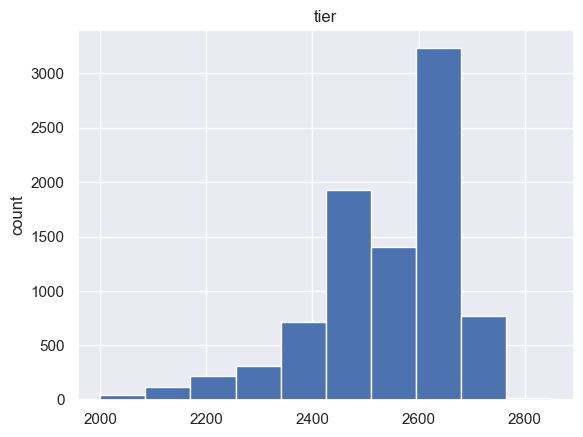

In [13]:
df.hist('tier')
plt.ylabel('count')
plt.show();

#### Num games per tier per player

/var/folders/r7/3_z3p06n3m79fcylhf7268r00000gn/T/ipykernel_18089/723142817.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist('tier', by='player', ax=ax);


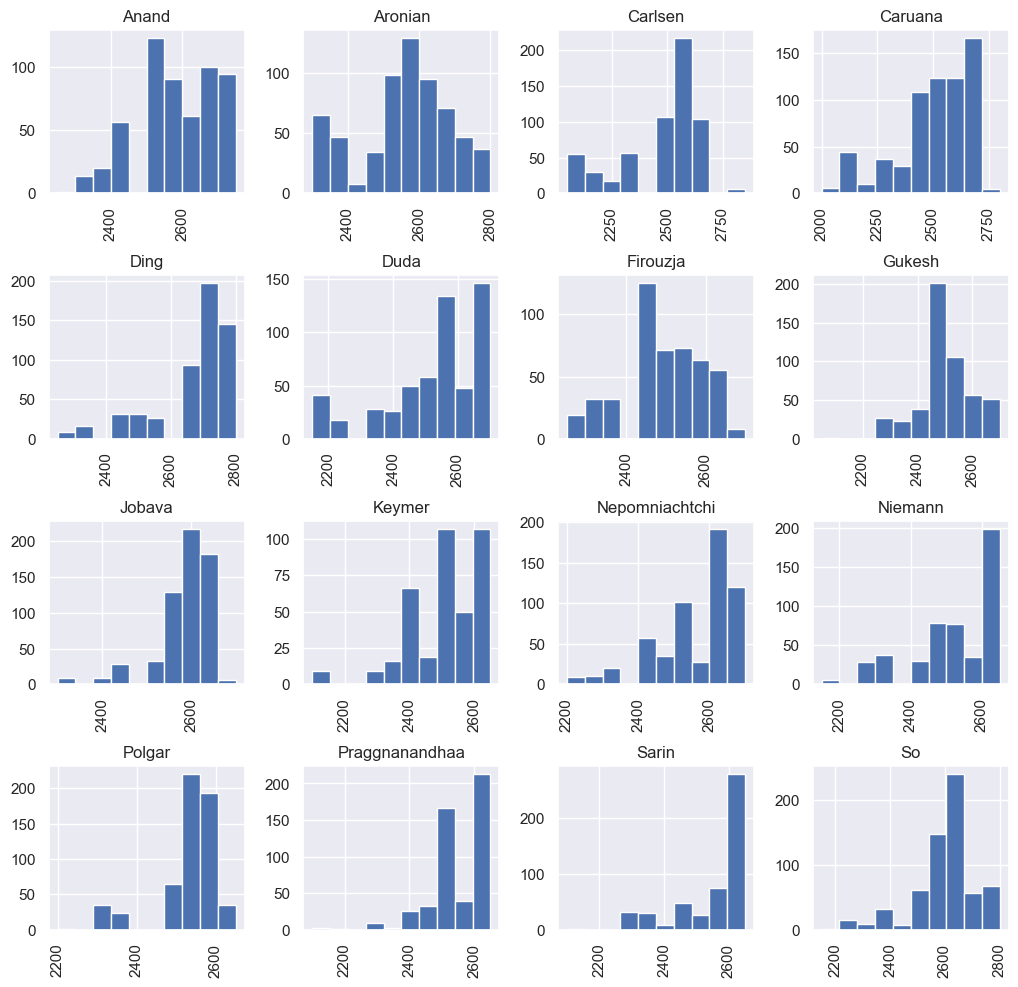

In [14]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
df.hist('tier', by='player', ax=ax);

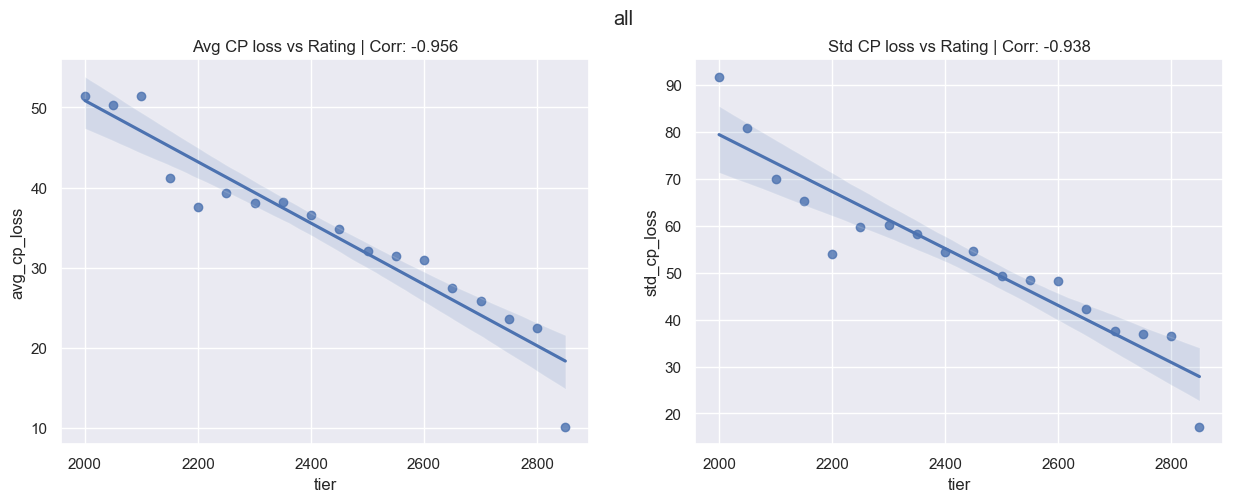

In [15]:
plot_acpl_and_stdcpl_by_tier(df, 'all')

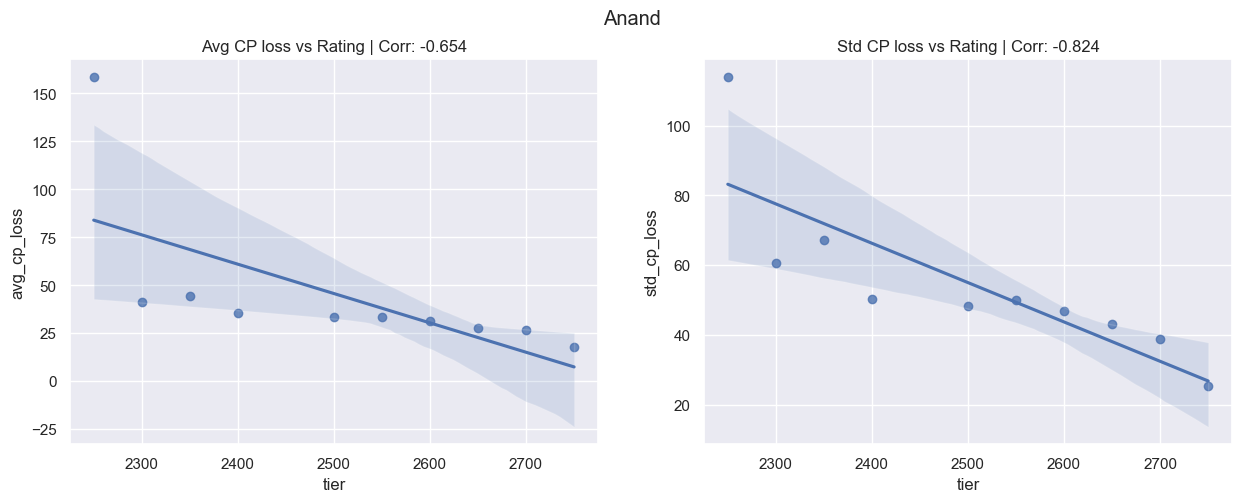

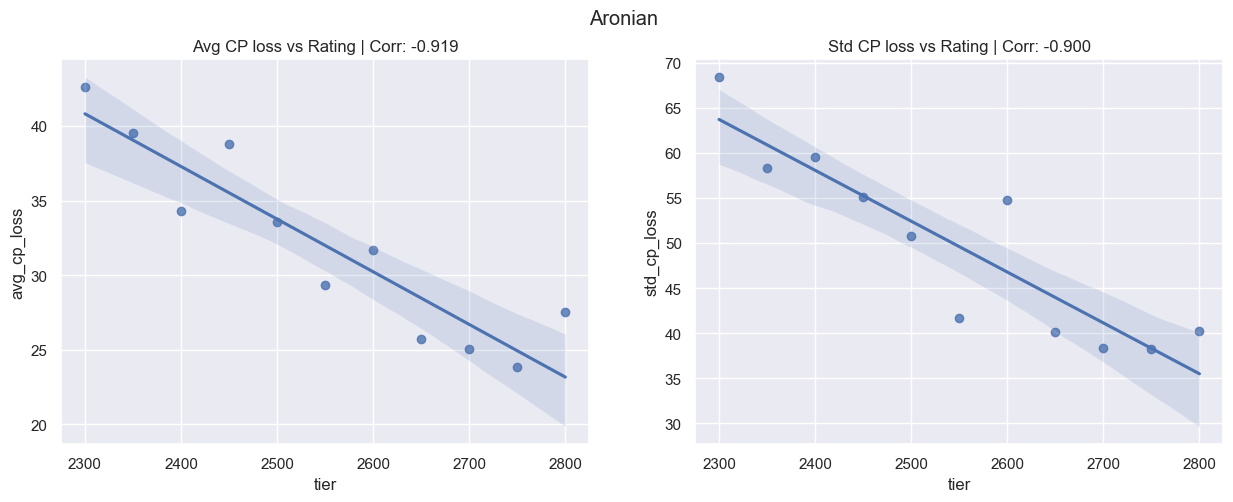

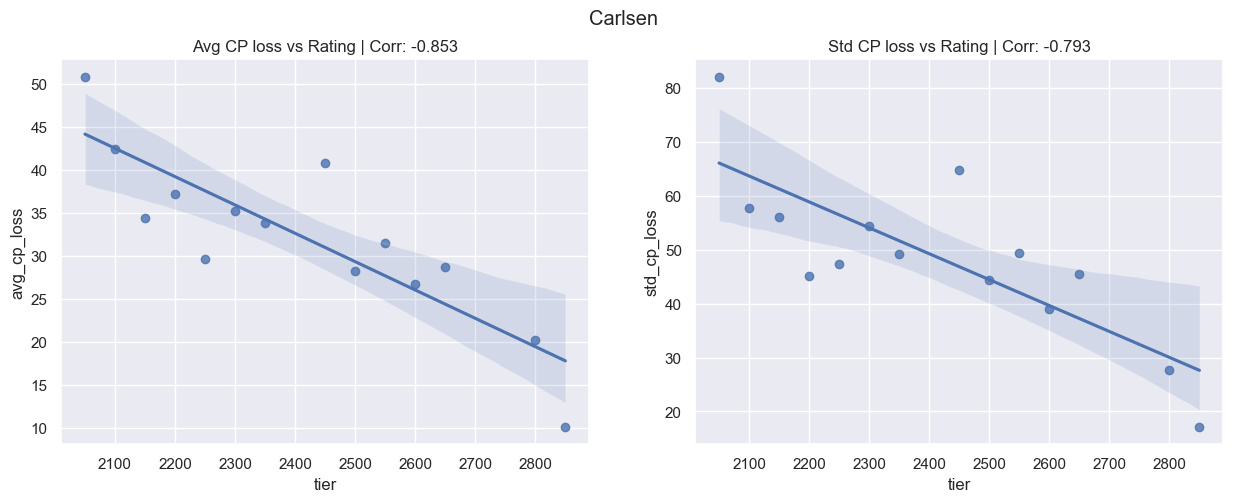

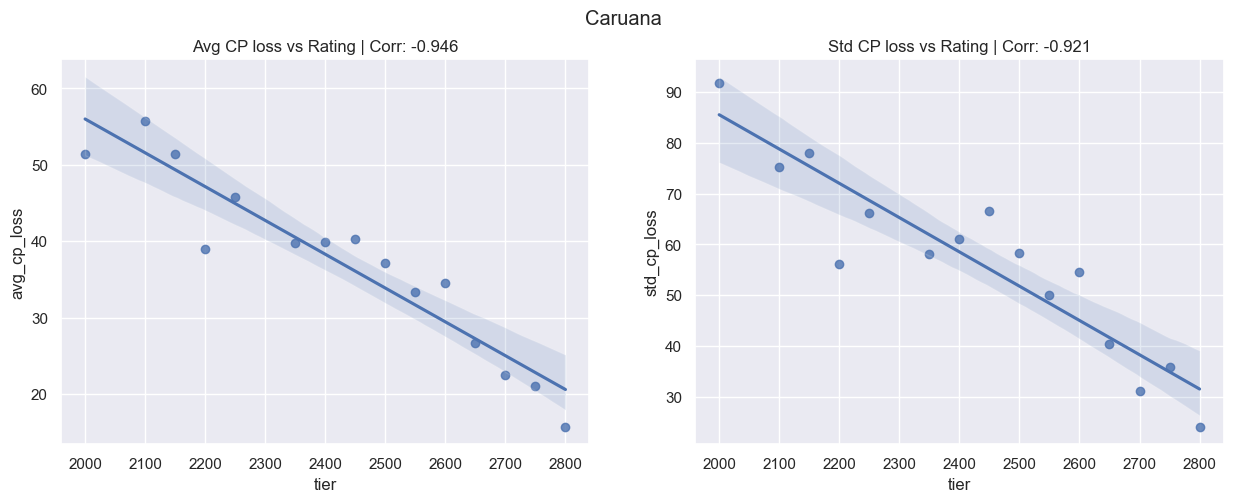

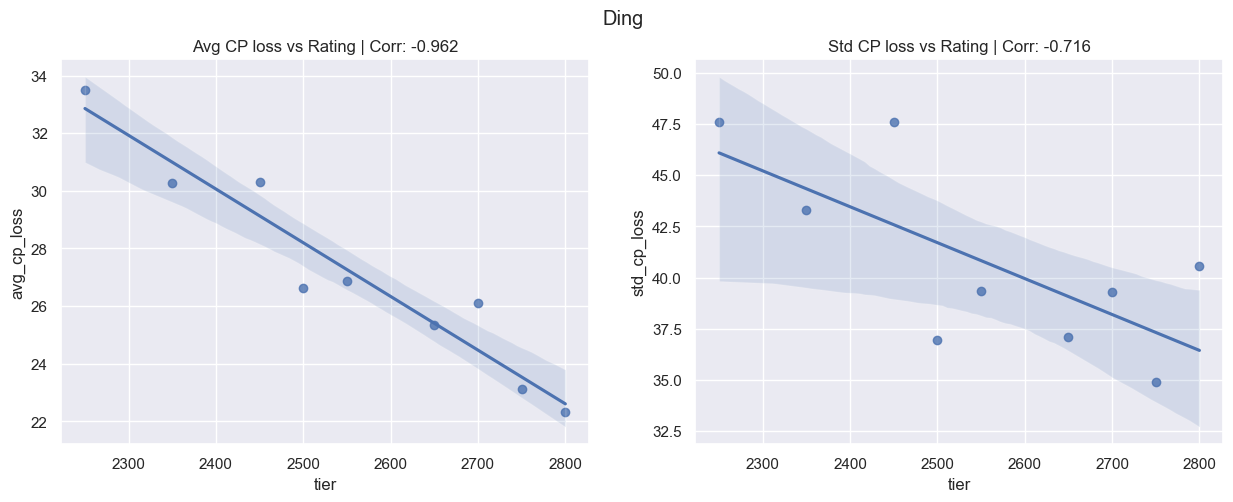

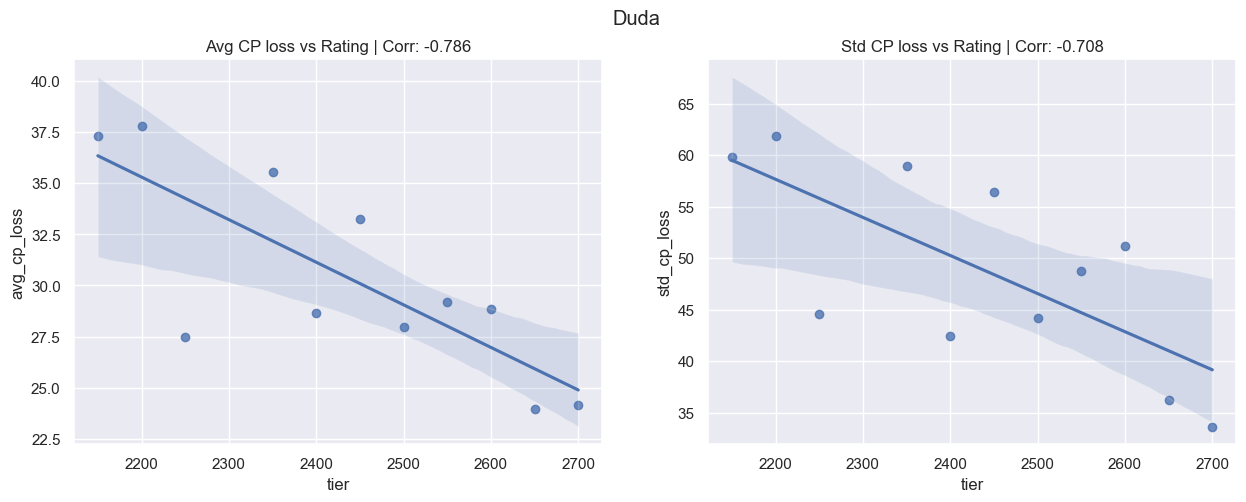

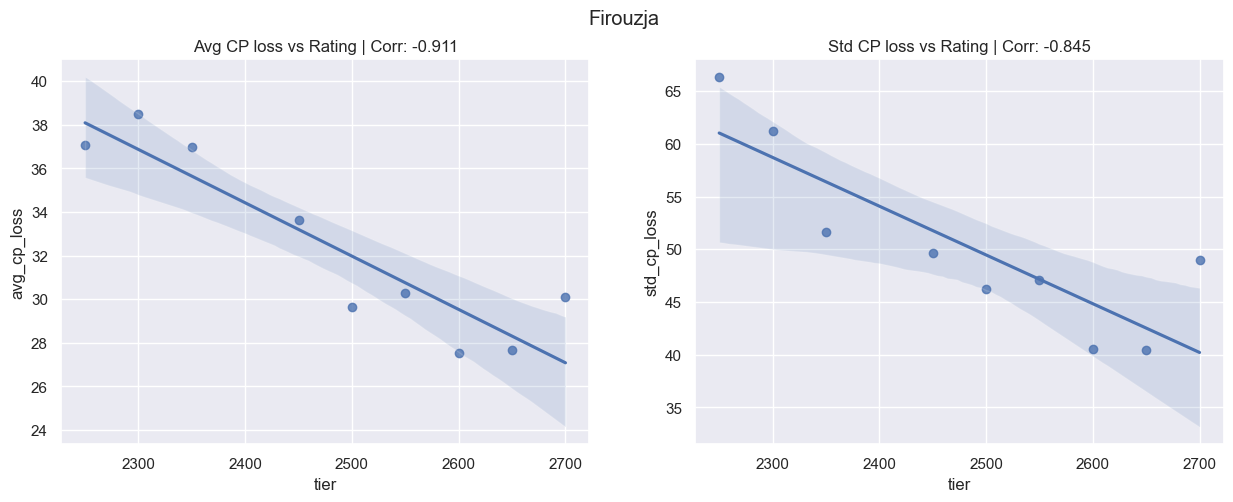

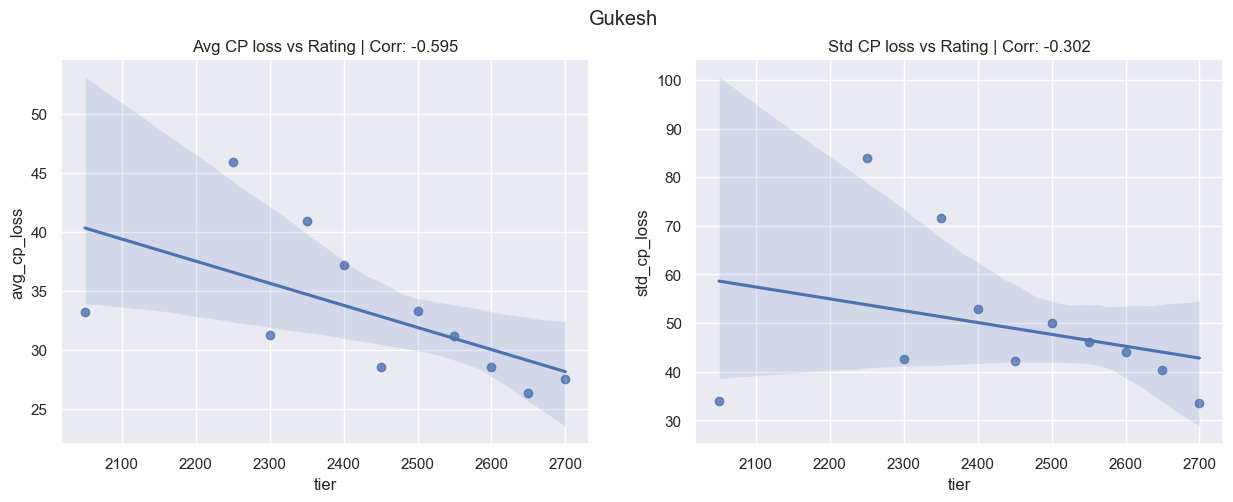

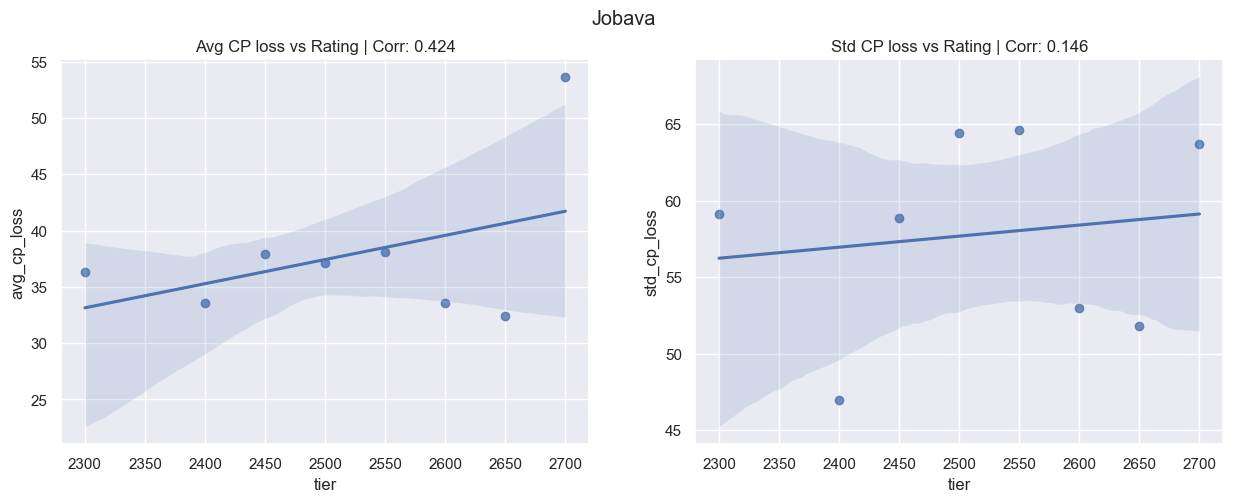

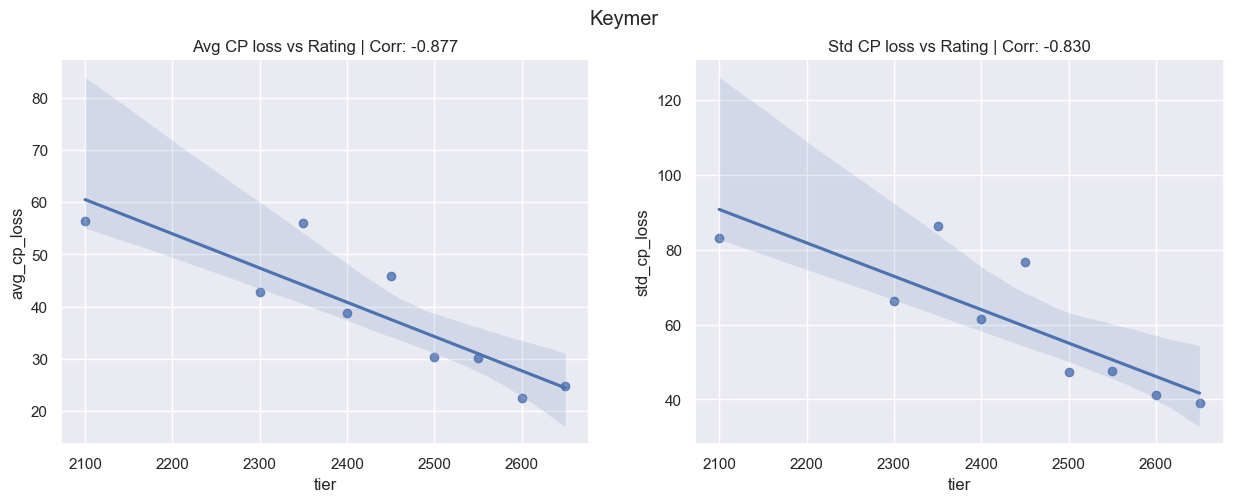

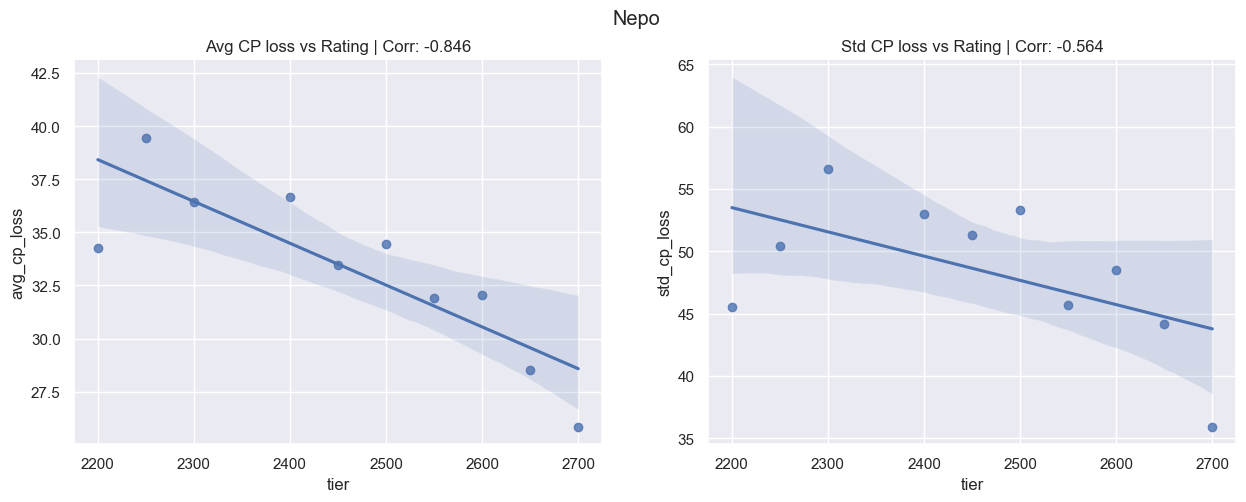

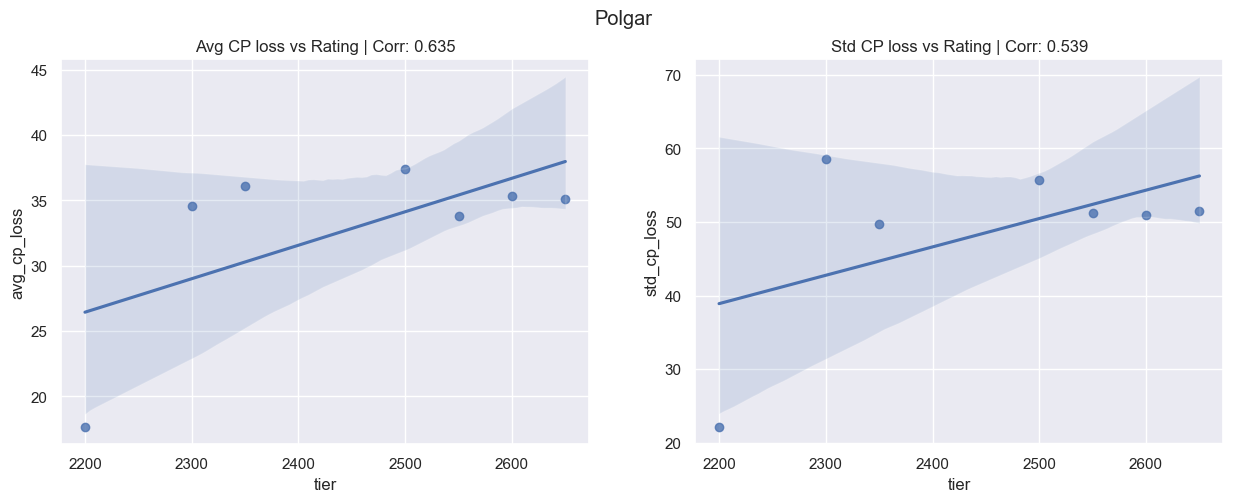

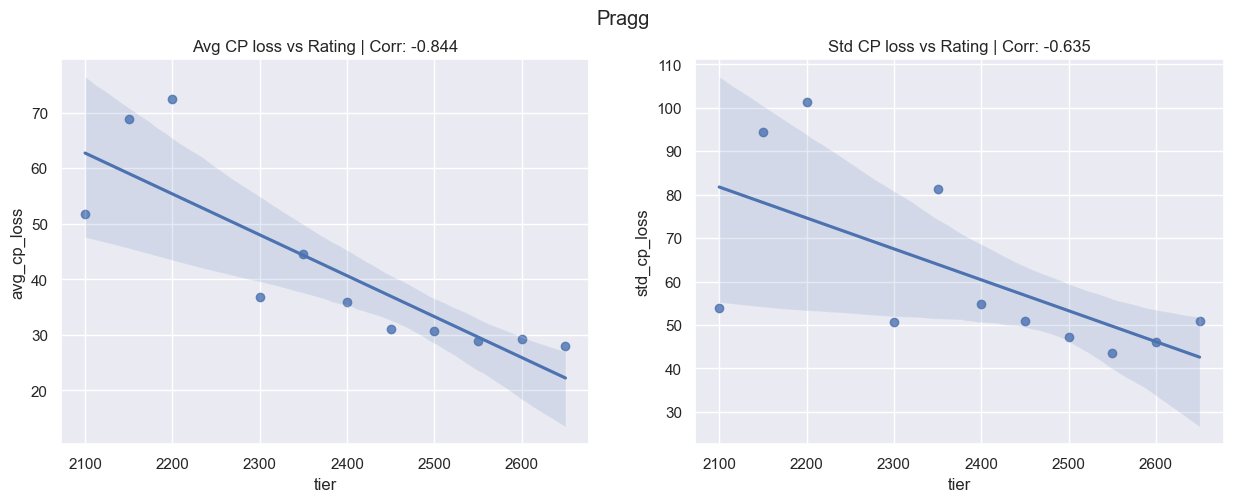

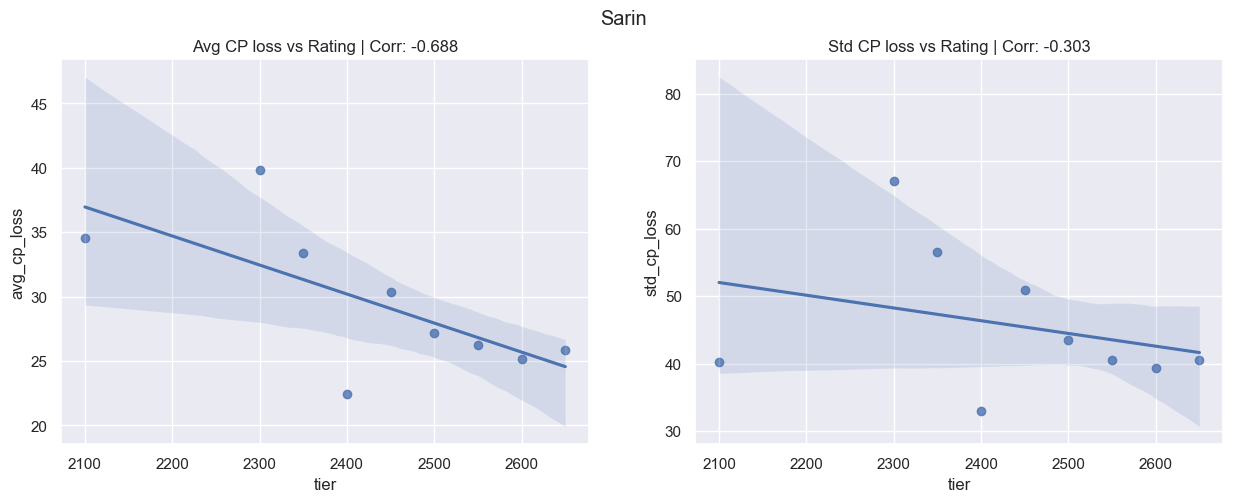

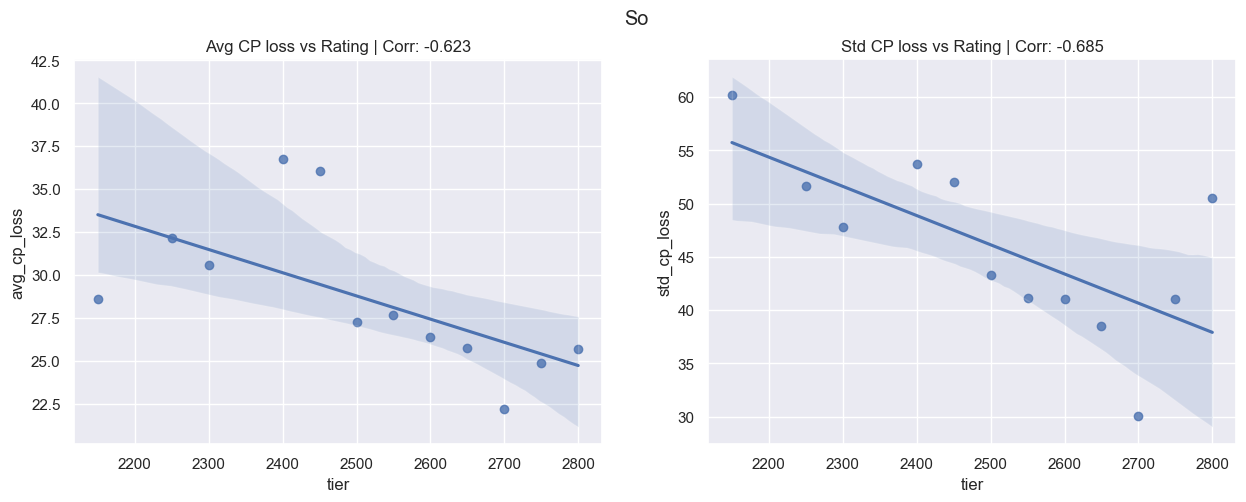

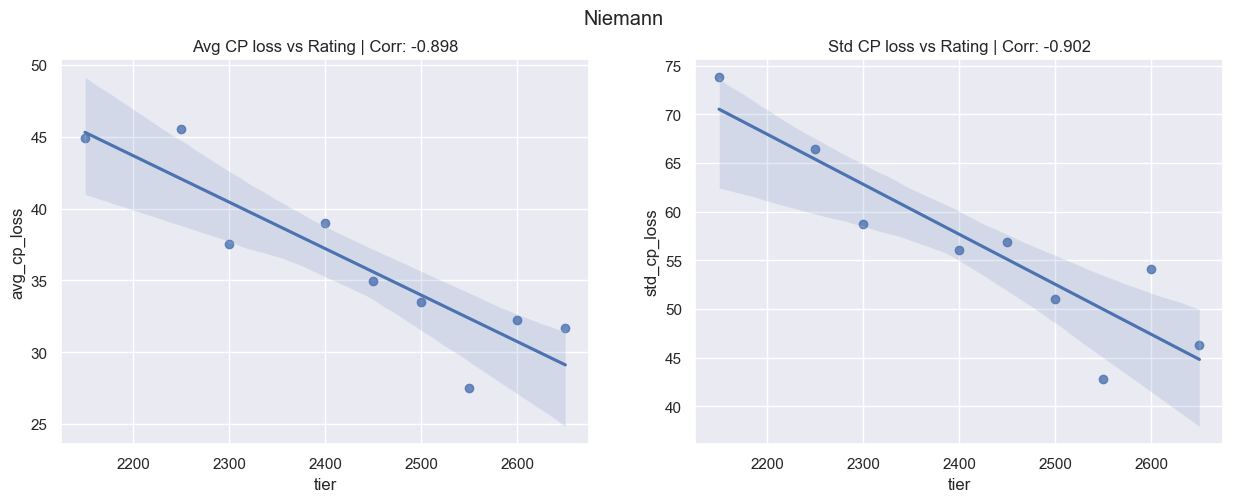

In [16]:
plot_acpl_and_stdcpl_by_tier(df, 'Anand') 
plot_acpl_and_stdcpl_by_tier(df, 'Aronian')
plot_acpl_and_stdcpl_by_tier(df, 'Carlsen')
plot_acpl_and_stdcpl_by_tier(df, 'Caruana')
plot_acpl_and_stdcpl_by_tier(df, 'Ding')
plot_acpl_and_stdcpl_by_tier(df, 'Duda')
plot_acpl_and_stdcpl_by_tier(df, 'Firouzja')
plot_acpl_and_stdcpl_by_tier(df, 'Gukesh')
plot_acpl_and_stdcpl_by_tier(df, 'Jobava')
plot_acpl_and_stdcpl_by_tier(df, 'Keymer')
plot_acpl_and_stdcpl_by_tier(df, 'Nepo')
plot_acpl_and_stdcpl_by_tier(df, 'Polgar')
plot_acpl_and_stdcpl_by_tier(df, 'Pragg')
plot_acpl_and_stdcpl_by_tier(df, 'Sarin')
plot_acpl_and_stdcpl_by_tier(df, 'So')
plot_acpl_and_stdcpl_by_tier(df, 'Niemann')

In [17]:
cp_loss_limits = [30, 20, 15, 10, 5, 3, 1]
num_games_per_player = df['player'].value_counts().to_dict()
sub_cp_limit_loss_df = pd.DataFrame(df['player'].unique(), columns=['player'])
for cp_loss_limit in cp_loss_limits:
    sub_cp_limit_loss_counts = df.groupby('player')['avg_cp_loss'].apply(lambda x: (x<cp_loss_limit).sum()).to_dict()
    sub_cp_limit_loss_df[f'sub_{cp_loss_limit}'] = sub_cp_limit_loss_df.apply(lambda x: 100*sub_cp_limit_loss_counts[x['player']] / num_games_per_player[x['player']], axis=1)

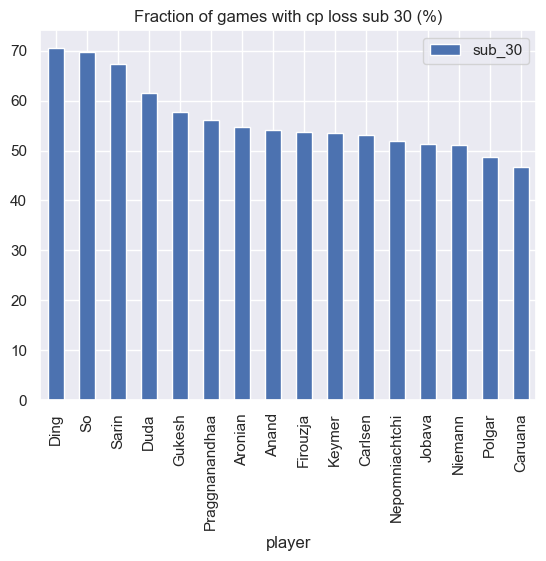

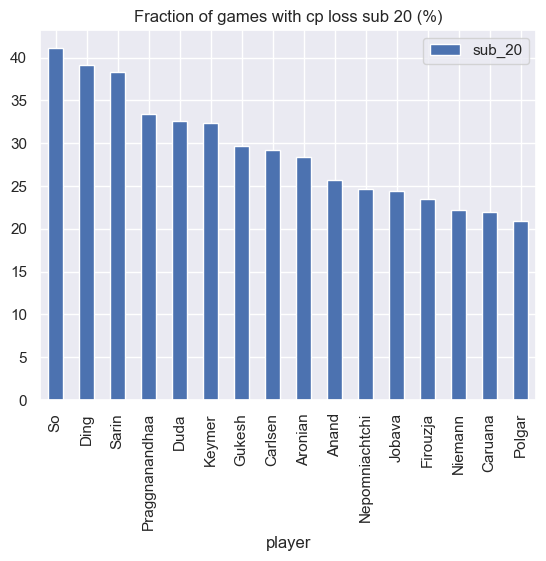

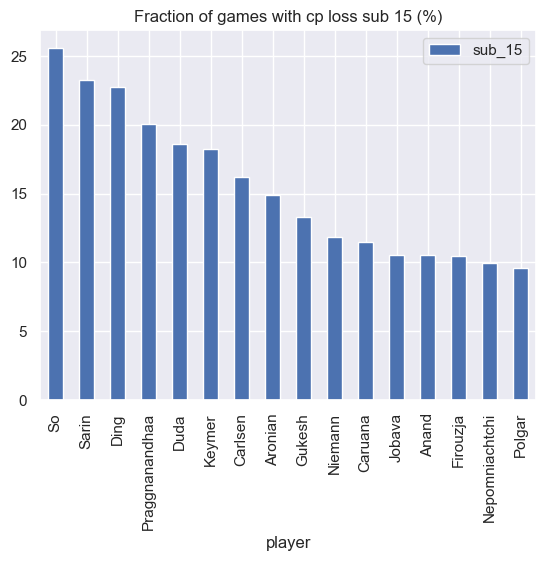

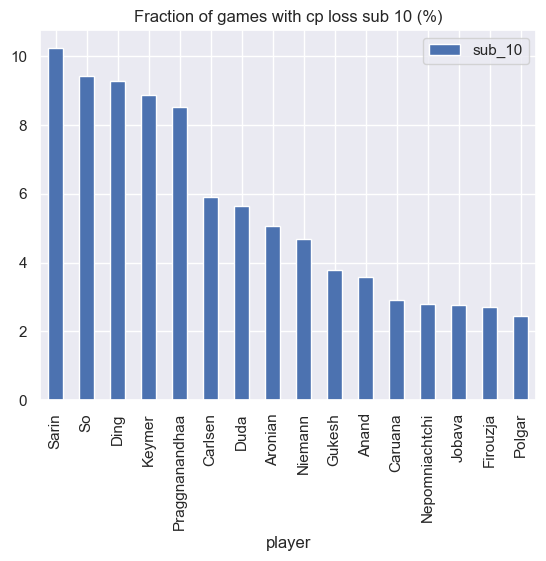

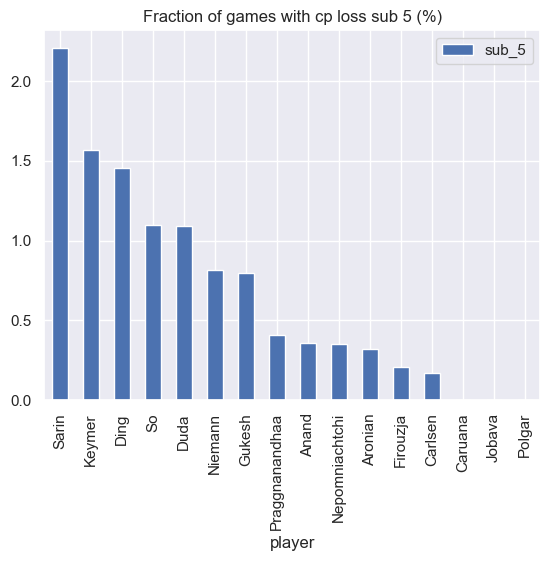

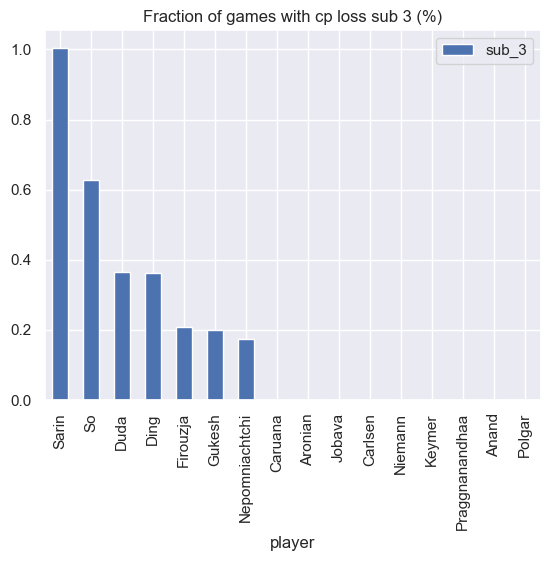

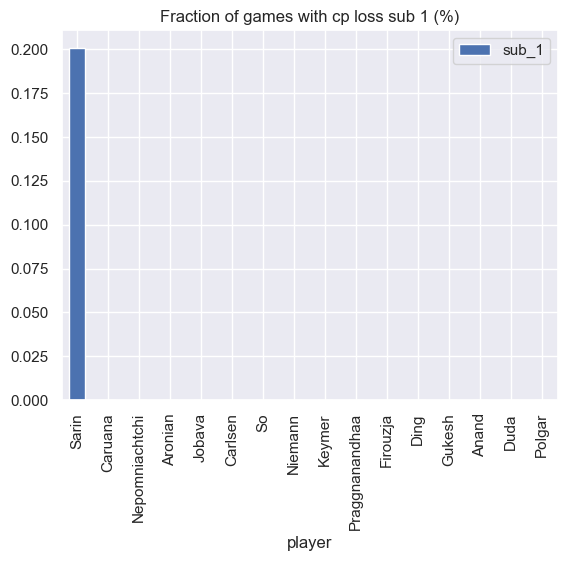

In [18]:
for cp_loss_limit in cp_loss_limits:
    title = f'Fraction of games with cp loss sub {cp_loss_limit} (%)'
    sub_cp_limit_loss_df.sort_values(by=[f'sub_{cp_loss_limit}'], ascending=False).plot.bar(x='player', y=f'sub_{cp_loss_limit}', title=title)

In [22]:
df.sort_values(['avg_cp_loss'], ascending=True).head(50)

,event,site,round,date,player,elo,color,opponent,result,avg_cp_loss,std_cp_loss,tier
4620,FIDE Grand Swiss 2021,Riga LAT,4.2,2021.10.30,Sarin,2652.0,white,"Ponkratov, Pavel",draw,0.000000,0.000000,2650
10901,38th Olympiad,Dresden GER,6,2008.11.19,So,2610.0,white,"Shirov,A",draw,1.350000,3.581550,2600
10143,Petrosian Memorial 2014,Moscow RUS,4.4,2014.11.08,Ding,2730.0,white,"Grischuk,A",draw,2.080000,3.554378,2700
11472,6th SPICE Cup GM,St Louis USA,7,2012.10.19,So,2677.0,black,"Balogh,C",draw,2.222222,2.973131,2650
4351,35th Cannes Open 2022,Cannes FRA,2.1,2022.02.22,Sarin,2656.0,black,"Girel, Joseph",draw,2.285714,8.241260,2650
8692,4th Young Stars of the World,Kirishi RUS,6,2006.05.14,Nepomniachtchi,2506.0,black,"Kulikov,Alex RUS",won,2.352941,8.670037,2500
6586,44th Olympiad 2022,Chennai IND,11.1,2022.08.09,Gukesh,2684.0,black,"Keymer, Vincent",draw,2.437500,5.854686,2650
11380,Asian Continental 2012,Ho Chi Minh City VIE,2.13,2012.05.06,So,2653.0,black,Nguyen Anh Dung,draw,2.450000,5.103675,2650
4626,FIDE Grand Swiss 2021,Riga LAT,7.9,2021.11.03,Sarin,2652.0,black,"Sargissian, Gabriel",draw,2.600000,3.184337,2650
5124,TV2 GM Open 2017,Fagernes NOR,4.3,2017.04.11,Sarin,2424.0,black,"Arvola, Benjamin",draw,2.625000,5.677532,2400


<AxesSubplot: xlabel='elo', ylabel='avg_cp_loss'>

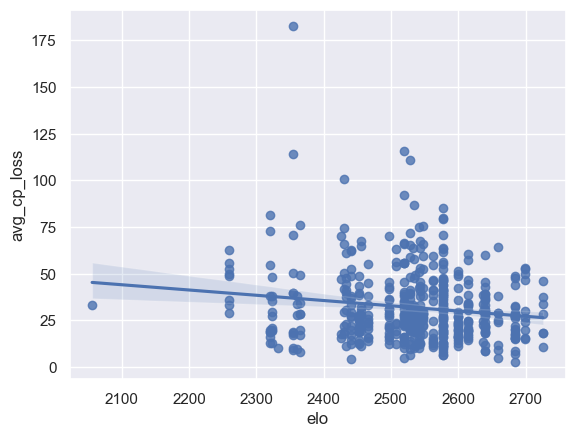

In [20]:
sns.regplot(x='elo', y='avg_cp_loss', data=df[df['player']=='Gukesh']) 

<AxesSubplot: xlabel='elo', ylabel='avg_cp_loss'>

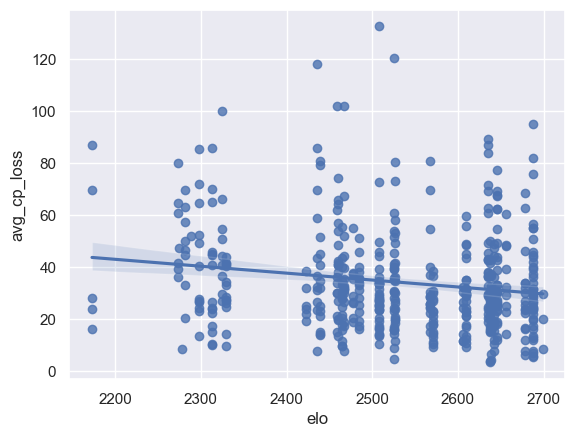

In [21]:
sns.regplot(x='elo', y='avg_cp_loss', data=df[df['player']=='Niemann']) 